In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from tqdm import tqdm

In [2]:
def sample_batch(batch_size, device='cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2, 0]] / 10
    data = data * np.array([1, -1])
    return torch.from_numpy(data).to(device)

In [3]:
class MLP(nn.Module):
    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        """
        :param N: Số bước thời gian tối đa (ví dụ: 40)
        :param data_dim: Kích thước dữ liệu đầu vào (ví dụ: 2D)
        :param hidden_dim: Số chiều của hidden layer
        """
        super(MLP, self).__init__()
        self.t_encoder = nn.Embedding(N, hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU()
        )
        self.output_layer = nn.Linear(hidden_dim*2, data_dim)

    def forward(self, x_t, t):
        """
        :param x_t: Dữ liệu input tại bước thời gian t, shape (batch_size, data_dim)
        :param t: Bước thời gian, shape (batch_size,) hoặc (1,)
        :return: Noise dự đoán epsilon, shape (batch_size, data_dim)
        """
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=x_t.device, dtype=torch.long)
        else:
            t = t.to(dtype=torch.long)
        t_emb = self.t_encoder(t)  # (batch_size, hidden_dim)
        x_feat = self.mlp(x_t)     # (batch_size, hidden_dim)
        concat = torch.cat([x_feat, t_emb], dim=-1)
        epsilon_pred = self.output_layer(concat)
        return epsilon_pred

In [4]:
class DiffusionModel():
    def __init__(self, T, model: nn.Module, device, dim=2):
        # Timestep của diffusion
        self.T = T
        self.device = device
        self.betas = (torch.sigmoid(torch.linspace(-18, 10, T, device=device)) * (3e-1 - 1e-5) + 1e-5)
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, 0)
        self.model = model
        self.dim = dim

    def forward_process(self, x0, t):
        """
        :param x0: Dữ liệu gốc, tensor [batch_size, self.dim]
        :param t: Số bước diffusion (số nguyên, 1 <= t <= T)
        :return: (x_t, epsilon) với 
                 x_t = sqrt(alpha_bar[t-1]) * x0 + sqrt(1 - alpha_bar[t-1]) * epsilon,
                 epsilon ~ N(0, I)
        """
        assert t > 0, 't should be greater than 0'
        assert t <= self.T, f't should be lower or equal than {self.T}'
        t_index = t - 1  
        alpha_bar_t = self.alphas_bar[t_index]
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        epsilon = torch.randn_like(x0)
        xt = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * epsilon
        return xt, epsilon
    
    @torch.no_grad()
    def reverse_process(self, xt, t):
        """
        Reverse diffusion step: Compute x_{t-1} from x_t
        :param xt: Noisy data at step t, tensor [batch_size, self.dim]
        :param t: Current timestep (số nguyên, 1 <= t <= T)
        :return: x_{t-1}
        """
        assert t > 0, 't should be greater than 0'
        assert t <= self.T, f't should be lower or equal than {self.T}'
        
        t_index = t - 1  
        
        beta_t = self.betas[t_index] 
        alpha_t = self.alphas[t_index]  
        alpha_bar_t = self.alphas_bar[t_index]  
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)

        # Tạo tensor t cho model, chuyển t sang chỉ số bắt đầu từ 0
        t_tensor = torch.full((xt.shape[0],), t_index, device=xt.device, dtype=torch.long)

        epsilon_theta = self.model(xt, t_tensor)

        # Tính toán mean cho x_{t-1}
        mean_xt_minus_1 = (1 / sqrt_alpha_t) * (xt - ((1 - alpha_t) / sqrt_one_minus_alpha_bar_t) * epsilon_theta)

        # Nếu t > 1, thêm noise ngẫu nhiên
        if t > 1:
            z = torch.randn_like(xt)
            sigma_t = torch.sqrt(beta_t)
            mean_xt_minus_1 += sigma_t * z
        return mean_xt_minus_1

    @torch.no_grad()
    def sample(self, batch_size, device):
        noise = torch.randn((batch_size, self.dim), device=device)
        x = noise
        samples = [x]
        # Reverse process từ T xuống 1
        for t in range(self.T, 0, -1):
            x = self.reverse_process(x, t)
            samples.append(x)
        return samples[::-1]
    
    def get_loss(self, x0):
        """
        :param x0: batch [batch_size, self.dim]
        :return: loss (MSE giữa noise dự đoán và noise thực tế)
        """
        # Chọn t ngẫu nhiên, tạo trực tiếp trên device với dtype long
        t = torch.randint(1, self.T + 1, (1,), device=x0.device, dtype=torch.long).item()
        
        xt, epsilon_true = self.forward_process(x0, t)
        
        t_tensor = torch.full((x0.shape[0],), t - 1, device=x0.device, dtype=torch.long)
        
        epsilon_pred = self.model(xt, t_tensor)
        
        loss = F.mse_loss(epsilon_pred, epsilon_true)
        return loss

\begin{equation}
\mathbf{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( \mathbf{x}_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \cdot \epsilon_\theta(\mathbf{x}_t, t) \right) + \sigma_t \mathbf{z} 

\quad \mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{equation}

In [5]:
@torch.no_grad()
def plot(diffusion_model, file_name, device):
    fontsize = 14
    fig = plt.figure(figsize=(10, 6))
    N = 5000
    x0 = sample_batch(N, device=device)
    samples = diffusion_model.sample(N, device=device)
    data = [x0.cpu(), diffusion_model.forward_process(x0, 20)[0].cpu(), diffusion_model.forward_process(x0, 40)[0].cpu()]
    for i in range(3):
        plt.subplot(2, 3, 1+i)
        plt.scatter(data[i][:, 0].detach().cpu().numpy(), data[i][:, 1].detach().cpu().numpy(), 
                    alpha=0.1, s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if i == 0: 
            plt.ylabel(r'$q(\mathbf{x}^{(0..T)})$', fontsize=fontsize)
            plt.title(r'$t=0$', fontsize=fontsize)
        elif i == 1:
            plt.title(r'$t=\frac{T}{2}$', fontsize=fontsize)
        elif i == 2:
            plt.title(r'$t=T$', fontsize=fontsize)

    time_steps = [0, 20, 40]
    for i in range(3):
        plt.subplot(2, 3, 4+i)
        plt.scatter(samples[time_steps[i]][:, 0].detach().cpu().numpy(), 
                    samples[time_steps[i]][:, 1].detach().cpu().numpy(),
                    alpha=0.1, c='r', s=1)
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.gca().set_aspect('equal')
        if i == 0: 
            plt.ylabel(r'$p(\mathbf{x}^{(0..T)})$', fontsize=fontsize)
    plt.savefig(file_name, bbox_inches='tight')
    plt.close()

In [6]:
import os

def train(diffusion_model, optimizer, batch_size, nb_epochs, device):
    training_loss = []
    for epoch in tqdm(range(nb_epochs)):
        x0 = sample_batch(batch_size, device=device)
        loss = diffusion_model.get_loss(x0.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())
        if epoch % 5000 == 0:
            plt.figure()
            plt.plot(training_loss)
            os.makedirs('./figs_noise/', exist_ok=True)
            plt.savefig(f'./figs_noise/training_loss_epoch_{epoch}.png')
            plt.close()
            plot(diffusion_model, f'./figs_noise/training_epoch_{epoch}.png', device)
    return training_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'
mlp_model = MLP(hidden_dim=128).to(device)
model = DiffusionModel(40, mlp_model, device)
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-4)

train(model, optimizer, 64_000, 300_000, device)

100%|██████████| 300000/300000 [55:00<00:00, 90.90it/s]  


[1.3727078437805176,
 1.2910020351409912,
 1.0713887214660645,
 1.3478586673736572,
 1.0713067054748535,
 1.1887091398239136,
 1.0695134401321411,
 1.3925535678863525,
 1.3024530410766602,
 1.3098939657211304,
 1.320451259613037,
 1.4656867980957031,
 1.0541223287582397,
 1.1364750862121582,
 1.0640119314193726,
 1.1793110370635986,
 1.0575411319732666,
 1.0248020887374878,
 1.2925999164581299,
 1.0854419469833374,
 1.047210931777954,
 1.1148803234100342,
 0.9596068859100342,
 1.2799937725067139,
 1.153104543685913,
 1.0242538452148438,
 1.0959843397140503,
 1.0787501335144043,
 1.4199527502059937,
 0.9424460530281067,
 1.2776374816894531,
 1.3061281442642212,
 1.3136848211288452,
 0.9491806030273438,
 0.9838070869445801,
 1.104261040687561,
 1.2062039375305176,
 0.9087167382240295,
 1.1149168014526367,
 1.1778570413589478,
 1.0818477869033813,
 1.039458155632019,
 1.1663167476654053,
 1.3792388439178467,
 1.0412123203277588,
 1.1673296689987183,
 1.2254854440689087,
 0.959845483303070

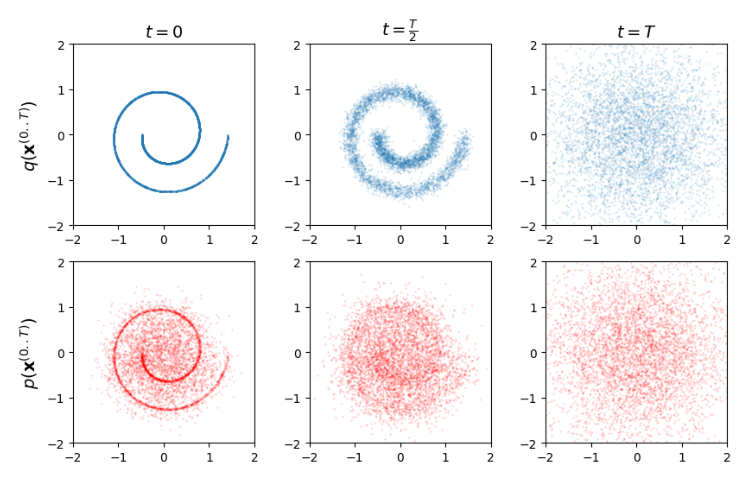

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "./figs_noise/training_epoch_295000.png"
image = mpimg.imread(image_path)

plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")  
plt.show()